# Install prerequisites

In [ ]:
!pip install tensorstore
import tensorstore as ts

In [ ]:
!pip install neuroglancer
import neuroglancer

In [ ]:
!pip install git+https://github.com/google-research/sofima

In [ ]:
# Pull the latest version instead of relying on a snapshotted release.
!pip install git+https://github.com/google-research/connectomics --upgrade

In [ ]:
!pip install --upgrade "jax[cuda]"

In [ ]:
!pip install gin-config

In [8]:
from concurrent import futures
import functools as ft

from connectomics.common import bounding_box
from connectomics.common import box_generator
from connectomics.volume import subvolume

import jax
import jax.numpy as jnp
import numpy as np

from sofima import mesh
from sofima import flow_field
from sofima import stitch_rigid
from sofima import stitch_elastic
from sofima.processor import warp

import skimage.exposure
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Data loading and tile layout definition

In [10]:
# The array below defines the spatial layout of the tiles.
# The values in the array should be tile IDs that will be passed to
# the `open_tile_volume` function below.

# +---> x
# |
# v y
tile_layout = np.array([
    [6, 13],
    [7, 12],
])

tile_to_coord = {}  # tile_num -> (ty, tx)
for tile_num in tile_layout.ravel():
  tile_to_coord[tile_num] = np.array(np.where(tile_layout == tile_num)).T[0]

# (ty, tx) -> i
coord_to_tile = {tuple(v.tolist()): k for k, v in tile_to_coord.items()}

In [ ]:
GCS_BUCKET = 'liconn-public'

def open_tile_volume(tile_id):
  return ts.open({
    'driver': 'n5',
    'kvstore': {
        'driver': 'gcs',
        'bucket': GCS_BUCKET,
    },
    'path': f'sofima/ExPID82_1/{tile_id}_clahe',
  }).result()

tile_volumes = {}
for i in tile_layout.ravel():
  tile_volumes[i] = open_tile_volume(i)

tile_size_xyz = next(iter(tile_volumes.values())).shape

# Coarse tile positioning

As a first step, we need to figure out the detailed relative position of every nearest neighbor tile pair.
To do this, we use a search strategy based on locating a small cube -- 50^3 extracted from the middle of the
'preceding' tile in the dimensions orthogonal to the overlap axis, and 100 px away from the edge along
overlap axis, within a larger region of the 'following tile' (1200 x 1200 x 400). This implicitly
assumes that:
  - the true overlap between the tiles is at least ~100 pixels and no more than ~400 pixels
  - that the offset between the tiles in the dimensions orthogonal to the overlap axis, relative to their
    initial position, is not larger than 600 px.

 These assumptions can be changed by adjusting the parameters below.

In [12]:
import gc

# Size of the 'query' cuboid in the preceding tile.
QUERY_R_ORTHO = 25
QUERY_R_OVERLAP = 25

# Distance of the 'query' cuboid away from the tile edge.
QUERY_OVERLAP_OFFSET = 100

# Size of the search area in the following tile.
SEARCH_OVERLAP = 400
SEARCH_R_ORTHO = 600


@ft.partial(jax.jit, static_argnames=('overlap',))
def _estimate_horiz(left, right, overlap):
  xc = flow_field.masked_xcorr(left, right, use_jax=True, dim=3)
  xc = xc.astype(np.float32)
  xc = xc[None, ...]
  r = flow_field._batched_peaks(xc, ((xc.shape[1] + 1) // 2, (xc.shape[2] + 1) // 2, overlap // 2), min_distance=2, threshold_rel=0.5)
  return r[0]

@ft.partial(jax.jit, static_argnames=('overlap',))
def _estimate_vert(top, bot, overlap):
  xc = flow_field.masked_xcorr(top, bot, use_jax=True, dim=3)
  xc = xc.astype(np.float32)
  xc = xc[None, ...]
  r = flow_field._batched_peaks(xc, ((xc.shape[1] + 1) // 2, overlap // 2, (xc.shape[3] + 1) // 2), min_distance=2, threshold_rel=0.5)
  return r[0]

def _estimate_offset_horiz(overlap: int, left: int, right: int) -> tuple[list[float], float]:
  mz = tile_size_xyz[2] // 2
  my = tile_size_xyz[1] // 2

  left = tile_volumes[left][tile_size_xyz[0]-overlap:,
                            my-SEARCH_R_ORTHO:my+SEARCH_R_ORTHO,
                            mz-SEARCH_R_ORTHO:mz+SEARCH_R_ORTHO].read().result().T
  right = tile_volumes[right][QUERY_OVERLAP_OFFSET:QUERY_OVERLAP_OFFSET + QUERY_R_OVERLAP*2,
                              my-QUERY_R_ORTHO:my+QUERY_R_ORTHO,
                              mz-QUERY_R_ORTHO:mz+QUERY_R_ORTHO].read().result().T

  left = left.astype(np.float32)
  right = right.astype(np.float32)
  left = left - left.mean()
  right = right - right.mean()

  r = np.array(_estimate_horiz(left, right, overlap))

  # the section at: overlap // 2 + r[0] relative to the start of left corresponds to right[100]
  # so the true overlap between the two blocks is:
  # 100 + overlap - ((overlap // 2) + r[0])

  return [QUERY_OVERLAP_OFFSET + QUERY_R_OVERLAP + overlap - ((overlap // 2) + r[0]), r[1], r[2]], abs(r[4])


def _estimate_offset_vert(overlap: int, top: int, bot: int) -> tuple[list[float], float]:
  mz = tile_size_xyz[2] // 2
  mx = tile_size_xyz[0] // 2

  top = tile_volumes[top][mx-SEARCH_R_ORTHO:mx+SEARCH_R_ORTHO, tile_size_xyz[1]-overlap:, mz-SEARCH_R_ORTHO:mz+SEARCH_R_ORTHO].read().result().T
  bot = tile_volumes[bot][mx-QUERY_R_ORTHO:mx+QUERY_R_ORTHO, QUERY_OVERLAP_OFFSET:QUERY_OVERLAP_OFFSET + QUERY_R_OVERLAP*2, mz-QUERY_R_ORTHO:mz+QUERY_R_ORTHO].read().result().T

  top = top.astype(np.float32)
  bot = bot.astype(np.float32)
  top = top - top.mean()
  bot = bot - bot.mean()
  r = np.array(_estimate_vert(top, bot, overlap))
  return [r[0], QUERY_OVERLAP_OFFSET + QUERY_R_OVERLAP + overlap - ((overlap // 2) + r[1]), r[2]], abs(r[4])


def compute_coarse_offsets(yx_shape: tuple[int, int],
                           tile_map: dict[tuple[int, int], int]) -> tuple[np.ndarray, np.ndarray]:
  """Computes coarse offsets for every tile.

  Args:
    yx_shape: shape of the tile grid
    tile_map: maps YX tile coordinates to tile IDs
  """

  def _find_offset(estimate_fn, pre: int, post: int, axis: int):
    offset, pr = estimate_fn(SEARCH_OVERLAP, pre, post)
    # Transform the number of overlapping voxels into an offset vector that
    # can be applied to the 'post' tile.
    offset[axis] = - offset[axis]
    return offset

  conn_x = np.full((3, 1, yx_shape[0], yx_shape[1]), np.nan)
  for x in range(0, yx_shape[1] - 1):
    for y in range(0, yx_shape[0]):
      if not ((y, x) in tile_map and (y, x + 1) in tile_map):
        continue
      print('processing', x, y)

      left = tile_map[(y, x)]
      right = tile_map[(y, x + 1)]
      gc.collect()
      conn_x[:, 0, y, x] = _find_offset(_estimate_offset_horiz, left, right, 0)
      # print(conn_x[:, 0, y, x])
    
  conn_y = np.full((3, 1, yx_shape[0], yx_shape[1]), np.nan)
  for y in range(0, yx_shape[0] - 1):
    for x in range(0, yx_shape[1]):
      if not ((y, x) in tile_map and (y + 1, x) in tile_map):
        continue
      print('processing', x, y)

      top = tile_map[(y, x)]
      bot = tile_map[(y + 1, x)]
      gc.collect()

      conn_y[:, 0, y, x] = _find_offset(_estimate_offset_vert, top, bot, 1)
      # print(conn_y[:, 0, y, x])
    
  return conn_x, conn_y

In [13]:
cx, cy = compute_coarse_offsets(tuple(tile_layout.shape), coord_to_tile)

processing 0 0
processing 0 1
processing 0 0
processing 1 0


In [14]:
cx

array([[[[-185.,   nan],
         [-191.,   nan]]],


       [[[ -44.,   nan],
         [ -40.,   nan]]],


       [[[  -3.,   nan],
         [  -7.,   nan]]]])

In [15]:
cy

array([[[[ -10.,  -17.],
         [  nan,   nan]]],


       [[[-227., -207.],
         [  nan,   nan]]],


       [[[  -5.,   -5.],
         [  nan,   nan]]]])

In [16]:
coarse_mesh = stitch_rigid.optimize_coarse_mesh(cx, cy, mesh_fn=stitch_rigid.elastic_tile_mesh_3d)

# Render a single XY slice to verify tile position estimates

In [17]:
solved = coarse_mesh
ox, oy, oz = [], [], []
for tile_id, (ty, tx) in tile_to_coord.items():
  ox.append([solved[0, 0, ty, tx]] + tile_size_xyz[0] * tx)
  oy.append([solved[1, 0, ty, tx]] + tile_size_xyz[1] * ty)
  oz.append([solved[2, 0, ty, tx]])
    
ox = np.array(ox)
oy = np.array(oy)
oz = np.array(oz)

# This defines the tile positions in the global coordinate system, after
# the initial coarse optimization.
oxyz = np.array([ox, oy, oz]).T[0, ...]
eoffs = oxyz

In [18]:
ext_min, ext_max = np.min(eoffs, axis=0), np.max(eoffs, axis=0)
z = 700

canvas_x = int(np.ceil(ext_max[0] - ext_min[0] + tile_size_xyz[0]))
canvas_y = int(np.ceil(ext_max[1] - ext_min[1] + tile_size_xyz[1]))
canvas = np.zeros((canvas_y, canvas_x), dtype=np.uint8)

for i, tile_id in enumerate(tile_to_coord.keys()):
  z0 = int(z - eoffs[i, 2])
  if z0 < 0 or z0 >= 1441:
    print(i, z0)
    continue

  x0 = int(np.ceil(eoffs[i, 0] - ext_min[0]))
  y0 = int(np.ceil(eoffs[i, 1] - ext_min[1]))
  sec = tile_volumes[tile_id][:, :, z0]
    
  canvas[y0:y0+sec.shape[1], x0:x0+sec.shape[0]] = sec.T

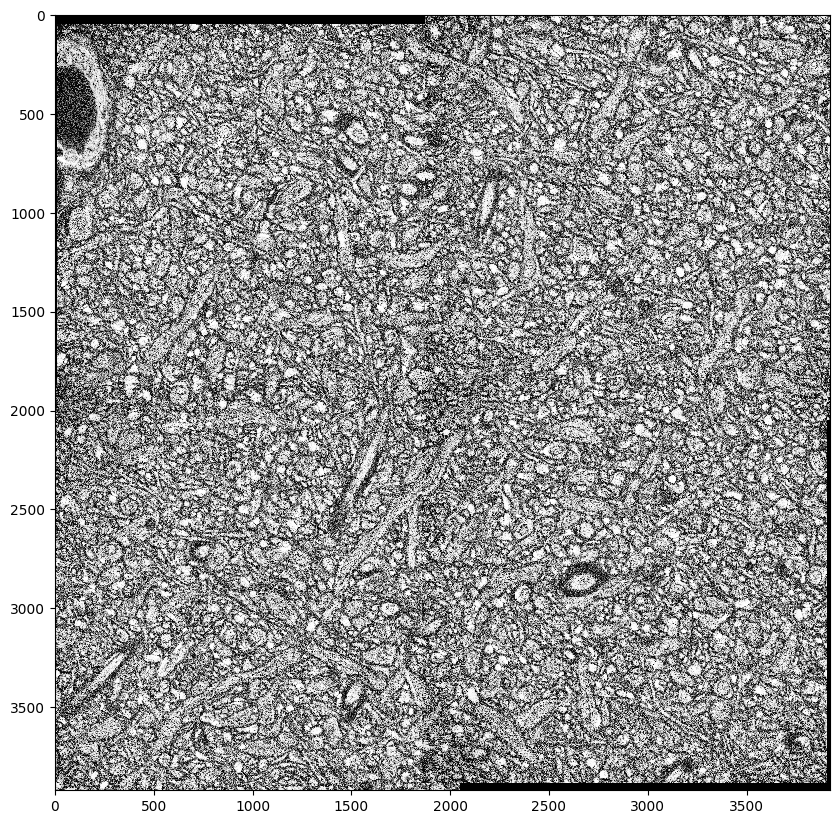

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 12))
plt.imshow(canvas, interpolation='nearest', cmap=plt.cm.Greys_r)

# Fine tile alignment

In [20]:
class SyncAdapter:
  """Makes it possible to use a TensorStore objects as a numpy array."""
    
  def __init__(self, tstore, i):
    self.tstore = tstore
    self.i = i

  def __getitem__(self, ind):
    return np.array(self.tstore[ind])

  def __getattr__(self, attr):
    return getattr(self.tstore, attr)

  @property
  def shape(self):
    return self.tstore.shape

  @property
  def ndim(self):
    return self.tstore.ndim

In [21]:
stride = 40, 40, 40

In [22]:
tile_map_xy = {}
for i, vol in tile_volumes.items():
  ty, tx = tile_to_coord[i]  # convert to 1zyx axis layout
  tile_map_xy[(tx, ty)] = SyncAdapter(vol.T[None, ...], i)

In [ ]:
flow_x, offsets_x = stitch_elastic.compute_flow_map3d(tile_map_xy,
                                                      tile_size_xyz,
                                                      cx, axis=0,
                                                      stride=stride,
                                                      patch_size=(80, 80, 80))

In [ ]:
flow_y, offsets_y = stitch_elastic.compute_flow_map3d(tile_map_xy,
                                                      tile_size_xyz, cy, axis=1,
                                                      stride=stride,
                                                      patch_size=(80, 80, 80))

In [32]:
from sofima import flow_utils

kwargs = {"min_peak_ratio": 1.4, "min_peak_sharpness": 1.4, "max_deviation": 5, "max_magnitude": 0, "dim": 3}
fine_x = {k: flow_utils.clean_flow(v, **kwargs) for k, v in flow_x.items()}
fine_y = {k: flow_utils.clean_flow(v, **kwargs) for k, v in flow_y.items()}

kwargs = {"min_patch_size": 10, "max_gradient": -1, "max_deviation": -1}
fine_x = {k: flow_utils.reconcile_flows([v], **kwargs) for k, v in fine_x.items()}
fine_y = {k: flow_utils.reconcile_flows([v], **kwargs) for k, v in fine_y.items()}

In [33]:
redo_x = []
# Print tiles without reliable flow estimates.
for k, v in fine_x.items():
  if np.all(np.isnan(v)):
    print(k, coord_to_idx[k[::-1]])
    redo_x.append(k)

In [34]:
# Print tiles without reliable flow estimates.
redo_y = []
for k, v in fine_y.items():
  if np.all(np.isnan(v)):
    print(k, coord_to_idx[k[::-1]])
    redo_y.append(k)

In [35]:
data_x = (cx[:, 0, ...], fine_x, offsets_x)
data_y = (cy[:, 0, ...], fine_y, offsets_y)

fx, fy, init_x, nbors, key_to_idx = stitch_elastic.aggregate_arrays(
    data_x, data_y, list(tile_map_xy.keys()),
    coarse_mesh[:, 0, ...], stride=stride, tile_shape=tile_size_xyz[::-1])

In [36]:
import jax.numpy as jnp

@jax.jit
def prev_fn(x):
  target_fn = ft.partial(stitch_elastic.compute_target_mesh, x=x, fx=fx, fy=fy, stride=stride)
  x = jax.vmap(target_fn)(nbors)
  return jnp.transpose(x, [1, 0, 2, 3, 4])

config = mesh.IntegrationConfig(dt=0.001, gamma=0., k0=0.01, k=0.1, stride=stride,
                                num_iters=1000, max_iters=20000, stop_v_max=0.001,
                                dt_max=100, prefer_orig_order=False,
                                start_cap=0.1, final_cap=10., remove_drift=True)

In [ ]:
x, ekin, t = mesh.relax_mesh(init_x, None, config, prev_fn=prev_fn, mesh_force=mesh.elastic_mesh_3d)

In [105]:
idx_to_tile_id = {}
for (x, y), idx in key_to_idx.items():
    idx_to_tile_id[idx] = tile_layout.ravel()[idx]

idx_tile_layout = np.arange((tile_layout.size)).reshape(tile_layout.shape)

In [38]:
np.savez_compressed('solved_mesh_st40.npz', x=x, key_to_idx=key_to_idx)

# Rendering of the stitched volume

In [210]:
class StitchAndRender3dTiles(warp.StitchAndRender3dTiles):

  cache = {}

  def _open_tile_volume(self, tile_id: int):
    if tile_id in self.cache:
      return self.cache[tile_id]
    
    actual_tile_id = idx_to_tile_id[tile_id]
      
    vol = ts.open({
      'driver': 'n5',
      'kvstore': {
          'driver': 'gcs',
          'bucket': GCS_BUCKET,
      },
      'path': self._tile_pattern_path.format(tile_id=actual_tile_id)
    }).result().T  # convert to zyx axis layout
    self.cache[tile_id] = SyncAdapter(vol, tile_id)
    return self.cache[tile_id]

In [225]:
# This is smaller than the actual bounding box to make rendering faster for the demo.
stitched = np.zeros((100, 4100, 4100), dtype=np.uint8)

In [226]:
renderer = StitchAndRender3dTiles(
    tile_map=idx_tile_layout,
    tile_pattern_path='sofima/ExPID82_1/{tile_id}_clahe',
    tile_mesh_path='solved_mesh_st40.npz',
    stride=stride,
    offset=[-70, -70, 30],
    parallelism=32
)

In [227]:
# renderer._collect_tile_boxes((1370, 2048, 2048))

In [228]:
box = bounding_box.BoundingBox(start=(0,0,0), size=ds_out.shape[::-1])
gen = box_generator.BoxGenerator(box, (512, 512, 512), (0, 0, 0), True)
renderer.set_effective_subvol_and_overlap((512, 512, 512), (0, 0, 0))

In [229]:
for i, sub_box in enumerate(tqdm(list(gen.boxes))):
    inp_subvol = subvolume.Subvolume(np.zeros(sub_box.size[::-1], dtype=np.uint8)[None, ...], sub_box)
    ret_subvol = renderer.process(inp_subvol)
    stitched[ret_subvol.bbox.to_slice3d()] = ret_subvol.data[0, ...]

# Visualize results

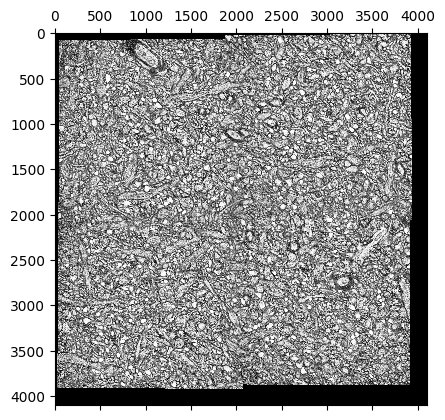

In [234]:
plt.matshow(stitched[60, :, :], cmap=plt.cm.Greys_r)

In [235]:
import neuroglancer

dimensions = neuroglancer.CoordinateSpace(names=['x', 'y', 'z'], units='nm', scales=[9,9,13])
viewer = neuroglancer.Viewer()
with viewer.txn() as s:
  s.dimensions = dimensions
  s.layers['em'] = neuroglancer.ImageLayer(source=neuroglancer.LocalVolume(stitched.T, dimensions))

viewer

http://127.0.0.1:41513/v/708eaf60f30fda4fcba7e3ebcfb6317e83322178/